In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 18/07/2019


In [2]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = '6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = [#'/home/gvolta/minitrees_test'
                           '/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/project/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'
                          ],
         make_minitrees = True)

In [3]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
project_path = '/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'

### Opening data

In [4]:
file = project_path + 'data_cut_new_SR1_S1PL.pkl'
data = pd.read_pickle(file)

In [5]:
#file4 = '/project/lgrandi/ccapelli/haxcache/bkg_newmaps_pax6.10.1_aftercuts.haxcache'
#data4 = hax.minitrees.load_cache_file(file4)

#data = [data1, data4]
#data = pd.concat(data, ignore_index=True)
#del data1, data4

In [6]:
data_white = data.copy()
data = data[data['s1'] < 2e4]

## Data

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


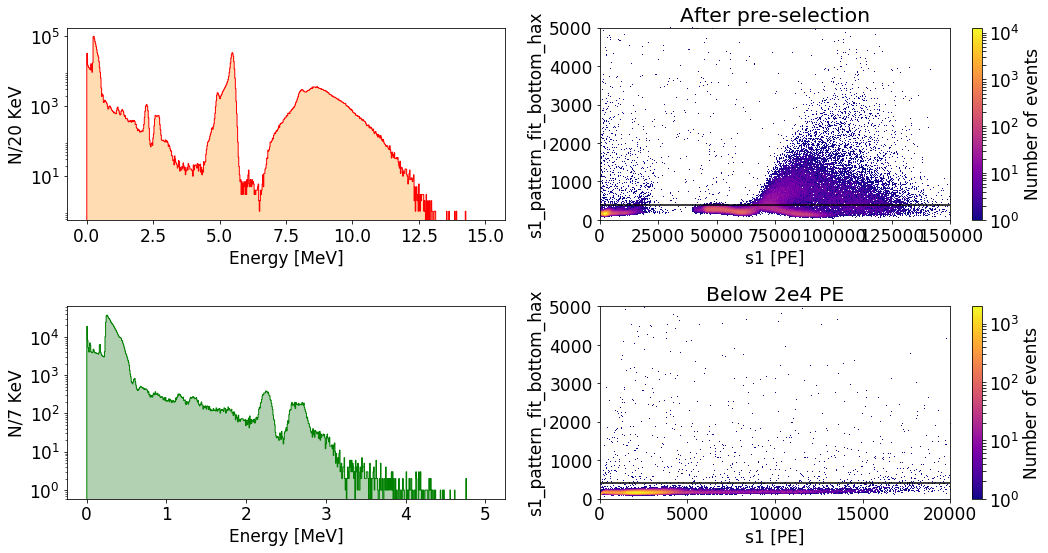

In [7]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.hist(data_white['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='bar', color='darkorange',
         alpha = 0.3)
plt.hist(data_white['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='step', color='red',
         alpha = 1)
plt.xlabel('Energy [MeV]')
plt.ylabel('N/20 KeV')
plt.yscale('log')

plt.subplot(222)
plt.hist2d(data_white['s1'], data_white['s1_pattern_fit_bottom_hax'], bins = (1000, 400), 
           range=((0,1.5e5), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('After pre-selection')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')
plt.hlines(y=400, xmax=1.5e5, xmin=0, colors='k', linestyles='solid')

plt.subplot(223)
plt.hist(data['CES']/10**6, bins = (700), 
         range=(0, 5), 
         histtype='bar', color='darkgreen',
         alpha = 0.3)
plt.xlabel('Energy [MeV]')
plt.hist(data['CES']/10**6, bins = (700), 
         range=(0, 5), 
         histtype='step', color='green',
         alpha = 1)
plt.xlabel('Energy [MeV]')
plt.ylabel('N/7 KeV')
plt.yscale('log')

plt.subplot(224)
plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (1000, 400), 
           range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('Below 2e4 PE')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')
plt.hlines(y=400, xmax=2e4, xmin=0, colors='k', linestyles='solid')


plt.tight_layout()
plt.show()

### Cut definition 

In [8]:
def S1PatternLikelihoodProfile_old(x, a, b, c, d, e):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5) + e*pow(x, 2)

def S1PatternLikelihoodProfile_old_2(x, a, b, c, d):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5)

In [9]:
def poly5(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5  

def inv_poly(x, p0, p1):
    return p0 / np.sqrt(x) + p1 / x

def poly1(x, p0, p1):
    return p0 + p1 * x

def poly2(x, p0, p1, p2):
    return p0 + p1 * x + p2 * x**2

def poly3(x, p0, p1, p2, p3):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3

def poly1_3(x, p0, p1, p3):
    return p0 + p1 * x + p3 * x**3

def exp(x, p0, p1, p3):
    return p0 + p1 *np.exp(-p3*x)

def S1PatternLikelihoodProfile_new(x, p0, p1, p2, p3, p4, p5):
    return poly5(x, p0, p1, p2, p3, p4, p5)

In [10]:
from statsmodels.stats.proportion import proportion_confint
binomial_error_method = 'wilson'
binomial_alpha = 0.68


def acceptance(data_before, data_after):
    after, bins=np.histogram(data_after ,bins=Bins, range=hist_range)
    before, bins=np.histogram(data_before ,bins=Bins, range=hist_range)

    acceptance = after/before
    error = proportion_confint(after, before, method=binomial_error_method, alpha=binomial_alpha)
    err_low = error[0]
    err_high = error[1]
    yerr_low, yerr_high = (acceptance - err_low, err_high - acceptance)
    err = (yerr_low, yerr_high)

    plt.errorbar(binn, acceptance, err,0, marker='.', markersize=5, linestyle="", linewidth=0.5, color='navy')
    plt.axhline(y=1, color='k',linestyle='--')
    plt.ylabel('acceptance')
    plt.ylim(0,1.05)

The definition of the cut has been divided into two region: at low-energy has been used the same fucntion of SR1, for the other values a new function has been used in order to follow better the data distribution. The parameter space has been divided in equally spaced slice of $s1$ and, as input for cut profile fitting, the $\mu+3\sigma$ of the normal distribution for each slices has been used.

# On z

In [11]:
hist_1, xbins_1, ybins_1 = np.histogram2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_bottom_hax'],
                                         bins=(100,800), 
                                         range=((-83.45, -13.45), (0.0,1000))
                                         )

ybins_center_z = np.asarray([0.5*(ybins_1[i]+ybins_1[i+1]) for i in range(len(ybins_1)-1)])
xbins_center_z = np.asarray([0.5*(xbins_1[i]+xbins_1[i+1]) for i in range(len(xbins_1)-1)])

#perc_1 = np.empty(len(xbins_center_1))
#for i in tqdm(range(len(hist_1))):
perc_z = percentile_numeric(hist = hist_1, xbins= xbins_1, ybins = ybins_1, q=0.98)
    #perc_1[i] = percentile(index = i, hist=hist_1, ybins=ybins_1, xbins=xbins_1, q=0.997, var1='s1', var2='s1 patter fit hax')
    
#xbins_center_valid_1, perc_valid_1 = dropNaNforFit(xbins_center_1, perc_1)
#xbins_center_valid_1, perc_valid_1 = dropNegforFit(xbins_center_valid_1, perc_valid_1)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit
del hist_1, xbins_1, ybins_1

100%|██████████| 100/100 [00:00<00:00, 2827.84it/s]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


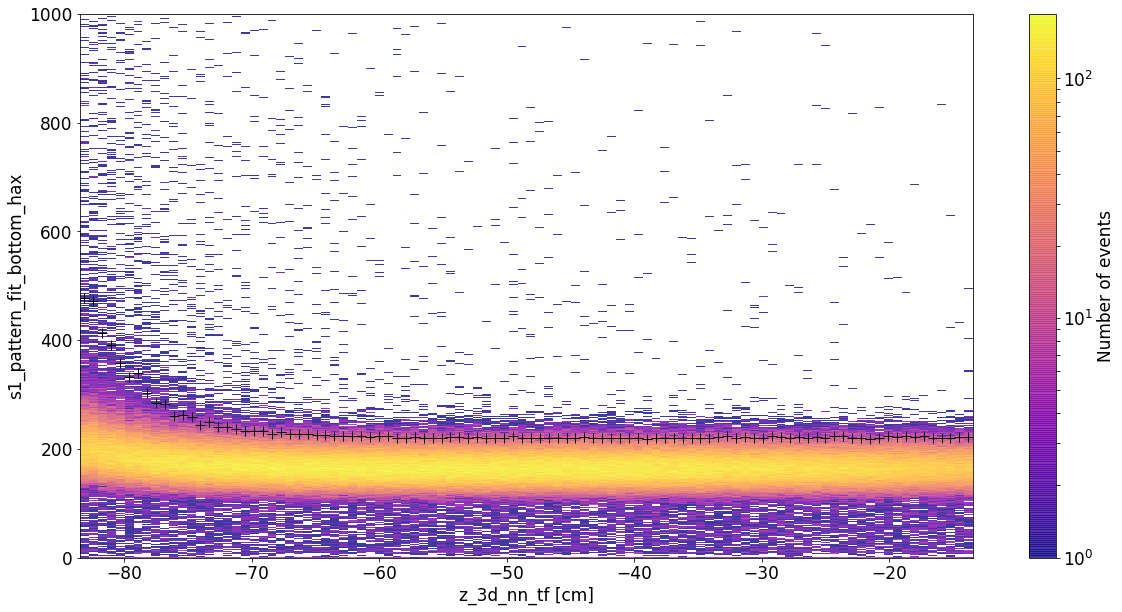

In [12]:
hist_z, xbins_z, ybins_z, _ = plt.hist2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_bottom_hax'],
                                         bins=(100,1000), 
                                         range=((-83.45, -13.45), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.8)
plt.plot(xbins_center_z, perc_z, 'k+', ms = 10)
plt.colorbar(label='Number of events')

plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_bottom_hax')

del hist_z, xbins_z, ybins_z, _

## Fit of the cut

popt_z:  [  2.21002321e+02   5.64886704e-07   2.40635501e-01] 

pcov_z:  [[  2.10120294e-01  -3.23345594e-08   6.86173917e-04]
 [ -3.23345594e-08   3.52928243e-14  -7.64880074e-10]
 [  6.86173917e-04  -7.64880074e-10   1.65872288e-05]]


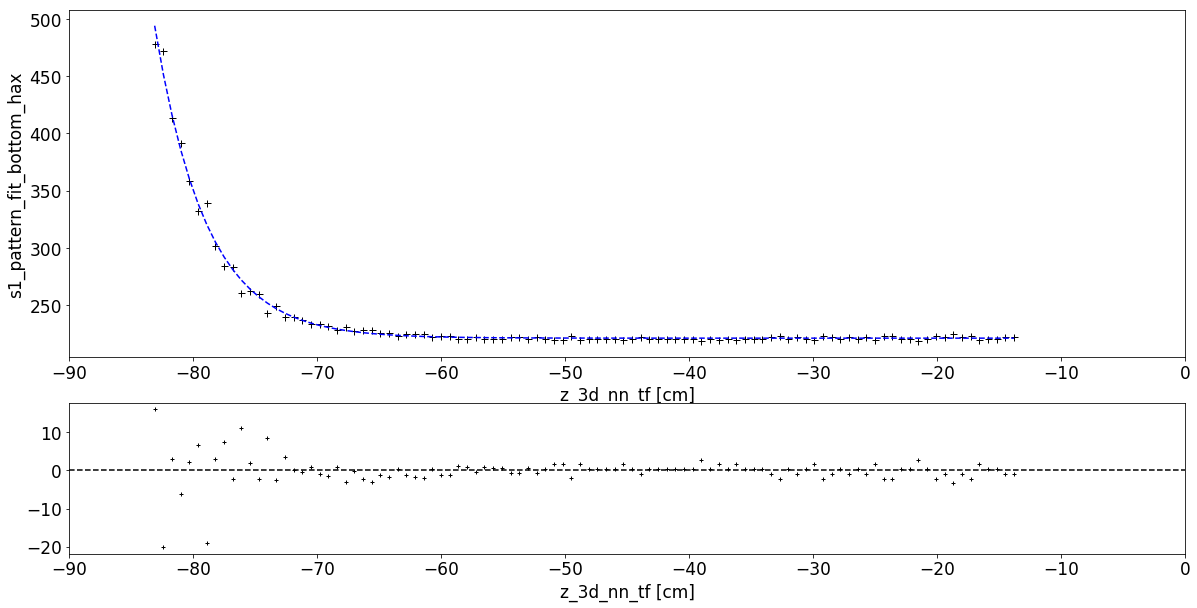

In [13]:
init_z = [2.085e+02,   2.47289420e-07,   2.40508404e-01]

popt_z, pcov_z = curve_fit(exp, xbins_center_z, perc_z, p0=init_z)
print('popt_z: ', popt_z ,'\n\npcov_z: ', pcov_z)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_z, perc_z, 'k+', ms = 7)
plt.plot(xbins_center_z, exp(xbins_center_z, *popt_z), 'b--')
plt.xlim(-90,0)

plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_z, exp(xbins_center_z, *popt_z) - perc_z, 'k+', ms=4)
plt.hlines(y=0, xmin=-90, xmax = 0 , linestyles='dashed')
plt.xlim(-90,0)
plt.xlabel('z_3d_nn_tf [cm]')

### Cut

In [14]:
data_cut_z = data.copy()
data_cut_z['CutS1PF_z'] = (data_cut_z['s1_pattern_fit_bottom_hax'] < exp(data_cut_z['z_3d_nn_tf'], *popt_z))
data_cut_z = hax.cuts.selection(data_cut_z, data_cut_z['CutS1PF_z'] == True)

Unnamed selection: 19629 rows removed (97.73% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


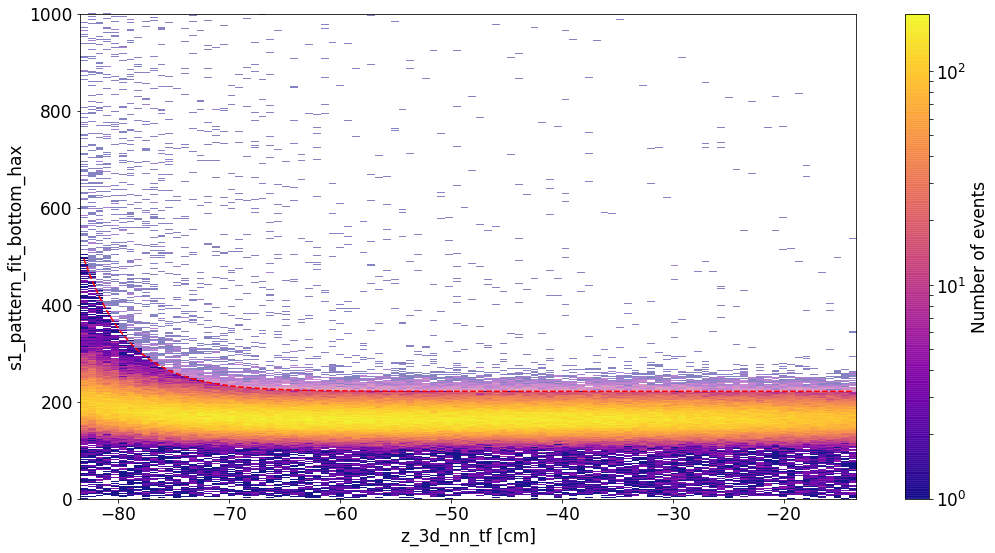

In [15]:
y = []
for i in range(len(xbins_center_z)):
    y.append(exp(xbins_center_z[i], *popt_z))

plt.figure(figsize=(15,8))
hist_z, xbins_z, ybins_z, _ = plt.hist2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_bottom_hax'],
                                         bins=(100,1000), 
                                         range=((-83.45, -13.45), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.5)
hist_z_cut, xbins_z_cut, ybins_z_cut, _ = plt.hist2d(data_cut_z['z_3d_nn_tf'], 
                                         data_cut_z['s1_pattern_fit_bottom_hax'],
                                         bins=(100,1000), 
                                         range=((-83.45, -13.45), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.9)
plt.colorbar(label='Number of events')
plt.plot(xbins_center_z, y, 'r--', label = 'S1 Pattern Likelihood Cut')
#plt.legend(loc='best')
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()
hist_z[np.isnan(hist_z)] = 0
hist_z_cut[np.isnan(hist_z_cut)] = 0

Unnamed selection: 0 rows removed (100.00% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


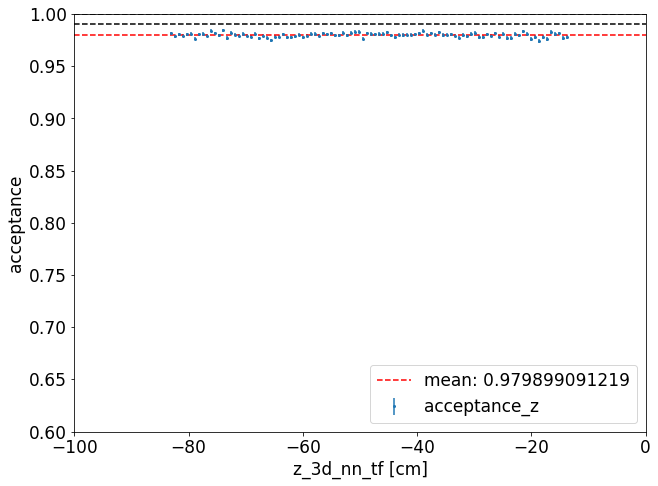

In [16]:
bin_centers_acceptance_z = []
acceptance_z = []
sigma_z = []
for i in range(len(xbins_z_cut)-1):
        bin_centers_acceptance_z.append((xbins_z_cut[i+1] + xbins_z_cut[i])/2.)
        acceptance_z.append(hist_z_cut[i].sum()/hist_z[i].sum())
        sigma_z.append(np.sqrt(acceptance_z[i]*(1-acceptance_z[i])/hist_z[i].sum()))
        
bin_centers_acceptance_z = np.array(bin_centers_acceptance_z)
acceptance_z = np.array(acceptance_z)
sigma_z = np.array(sigma_z)

tmp = np.array([bin_centers_acceptance_z, acceptance_z, sigma_z])
tmp = tmp.transpose()
Acceptance_z = pd.DataFrame(tmp, 
                            columns=['bin_centers_acceptance_z', 'acceptance_z', 'sigma_z'])
Acceptance_z['NaN'] = Acceptance_z['sigma_z'].isnull()
Acceptance_z = hax.cuts.selection(Acceptance_z, Acceptance_z['NaN'] == False)

plt.figure(figsize=(10.24, 7.68))

plt.errorbar(Acceptance_z['bin_centers_acceptance_z'], Acceptance_z['acceptance_z'], yerr=Acceptance_z['sigma_z'], 
             linestyle = ' ', marker= 'o', markersize = 2)

plt.hlines(y=1, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=0.99, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=Acceptance_z['acceptance_z'].mean(), xmin=-100, xmax=0, linestyle = '--', 
           label='mean: '+str(Acceptance_z['acceptance_z'].mean()), color = 'red')
plt.legend(loc='lower right')
plt.xlim(-100, 0)
plt.ylim(0.60, 1.0)
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('acceptance')

del bin_centers_acceptance_z, acceptance_z, sigma_z
del hist_z, xbins_z, ybins_z
del hist_z_cut, xbins_z_cut, ybins_z_cut
del Acceptance_z, tmp

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


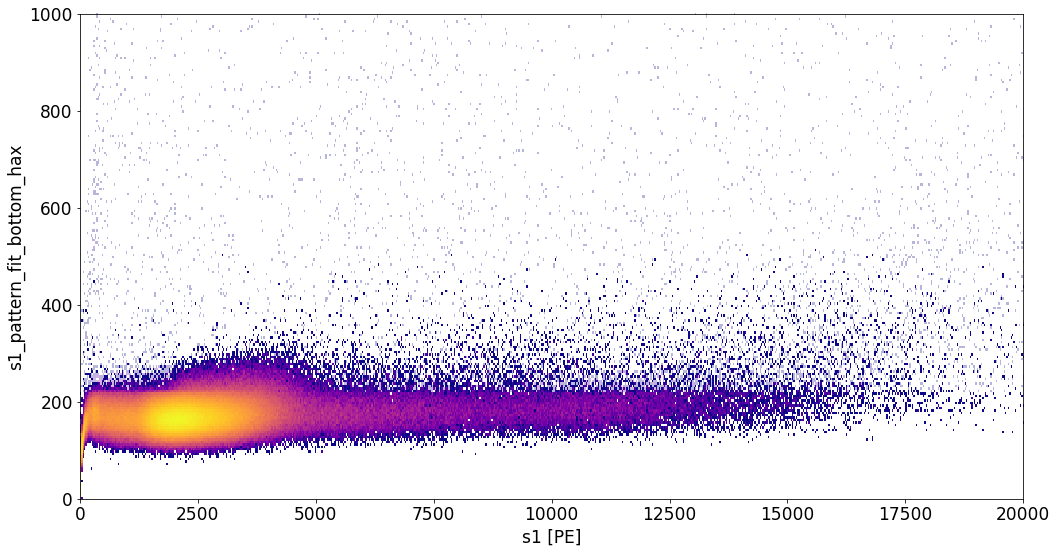

In [17]:
plt.figure(figsize=(15,8))
plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (700, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.3)
plt.hist2d(data_cut_z['s1'], data_cut_z['s1_pattern_fit_bottom_hax'], bins = (700, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
#plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')
plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


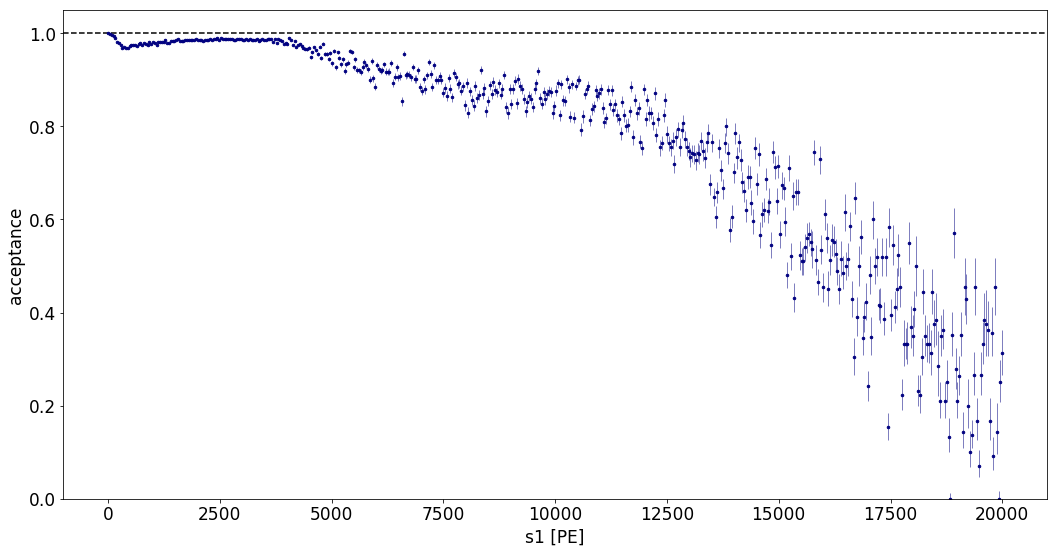

In [18]:
Bins=500
hist_range=([0, 2e4])  
binn=np.linspace(0,2e4,Bins)
fig = plt.figure(figsize=(15, 8))
acceptance(data.s1, data_cut_z.s1)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('s1 [PE]')
plt.legend(loc='best')
#plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()

## On S1

In [19]:
data = data_cut_z.copy()

100%|██████████| 10/10 [00:00<00:00, 12.01it/s]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


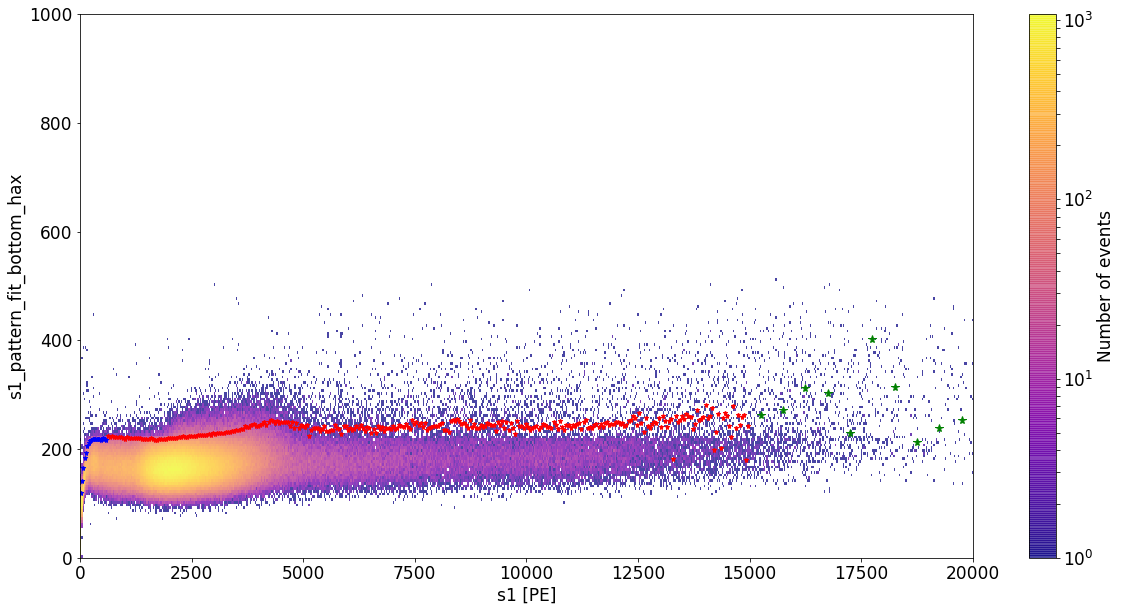

In [20]:
hist_1, xbins_1, ybins_1 = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (20, 200), 
                                   range=((0,600), (0,1000))
                                   )
ybins_center_1 = [0.5*(ybins_1[i]+ybins_1[i+1]) for i in range(len(ybins_1)-1)]
xbins_center_1 = [0.5*(xbins_1[i]+xbins_1[i+1]) for i in range(len(xbins_1)-1)]

perc_1 = np.empty(len(xbins_center_1))
for i in tqdm(range(len(hist_1))):
    perc_1[i] = percentile(index = i, hist=hist_1, ybins=ybins_1, xbins=xbins_1, q=0.98, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_1, perc_valid_1 = dropNaNforFit(xbins_center_1, perc_1)
xbins_center_valid_1, perc_valid_1 = dropNegforFit(xbins_center_valid_1, perc_valid_1)

hist_2, xbins_2, ybins_2 = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (300, 200), 
                                   range=((600,1.5e4), (0,1000))
                                   )
ybins_center_2 = [0.5*(ybins_2[i]+ybins_2[i+1]) for i in range(len(ybins_2)-1)]
xbins_center_2 = [0.5*(xbins_2[i]+xbins_2[i+1]) for i in range(len(xbins_2)-1)]

perc_2 = np.empty(len(xbins_center_2))
for i in tqdm(range(len(hist_2))):
    perc_2[i] = percentile(index = i, hist=hist_2, ybins=ybins_2, xbins=xbins_2, q=0.99, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_2, perc_valid_2 = dropNaNforFit(xbins_center_2, perc_2)
xbins_center_valid_2, perc_valid_2 = dropNegforFit(xbins_center_valid_2, perc_valid_2)

hist_3, xbins_3, ybins_3 = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (10, 200), 
                                   range=((1.5e4,2e4), (0,1000))
                                   )
ybins_center_3 = [0.5*(ybins_3[i]+ybins_3[i+1]) for i in range(len(ybins_3)-1)]
xbins_center_3 = [0.5*(xbins_3[i]+xbins_3[i+1]) for i in range(len(xbins_3)-1)]

perc_3 = np.empty(len(xbins_center_3))
for i in tqdm(range(len(hist_3))):
    perc_3[i] = percentile(index = i, hist=hist_3, ybins=ybins_3, xbins=xbins_3, q=0.98, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_3, perc_valid_3 = dropNaNforFit(xbins_center_3, perc_3)
xbins_center_valid_3, perc_valid_3 = dropNegforFit(xbins_center_valid_3, perc_valid_3)

hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (700, 200), 
                                               range=((0,2e4), (0,1000)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                               cmin = 1,alpha = 0.75)
plt.colorbar(label='Number of events')
plt.plot(xbins_center_valid_1, perc_valid_1, 'b*', lw=2, ms=5)
plt.plot(xbins_center_valid_2, perc_valid_2, 'r*', lw=2, ms=5)
plt.plot(xbins_center_valid_3, perc_valid_3, 'g*', lw=2, ms=8)

#plt.xlim(0,2e4)
#plt.ylim(0,700)

plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

xbins_center_valid = np.concatenate((xbins_center_valid_1, xbins_center_valid_2, xbins_center_valid_3))
perc_valid = np.concatenate((perc_valid_1, perc_valid_2, perc_valid_3))

plt.show()

# Fit of the cut

popt_1:  [  4.14522389e+01   2.13216329e+01  -8.32696659e-01   1.06931077e-02] 

pcov_1:  [[  5.06808967e+01  -9.50277375e+00   5.17747044e-01  -8.55857420e-03]
 [ -9.50277375e+00   1.95826062e+00  -1.12420109e-01   1.92086653e-03]
 [  5.17747044e-01  -1.12420109e-01   6.67908988e-03  -1.16904359e-04]
 [ -8.55857420e-03   1.92086653e-03  -1.16904359e-04   2.08394721e-06]]

popt_2:  [  2.08681547e+02   9.78555647e-03  -9.46246175e-07   3.29440758e-11] 

pcov_2:  [[  2.36908682e+01  -9.26068903e-03   9.88981568e-07  -3.10873173e-11]
 [ -9.26068903e-03   4.14984479e-06  -4.74924646e-10   1.56038291e-14]
 [  9.88981568e-07  -4.74924646e-10   5.71474318e-14  -1.95178373e-18]
 [ -3.10873173e-11   1.56038291e-14  -1.95178373e-18   6.89796382e-23]]


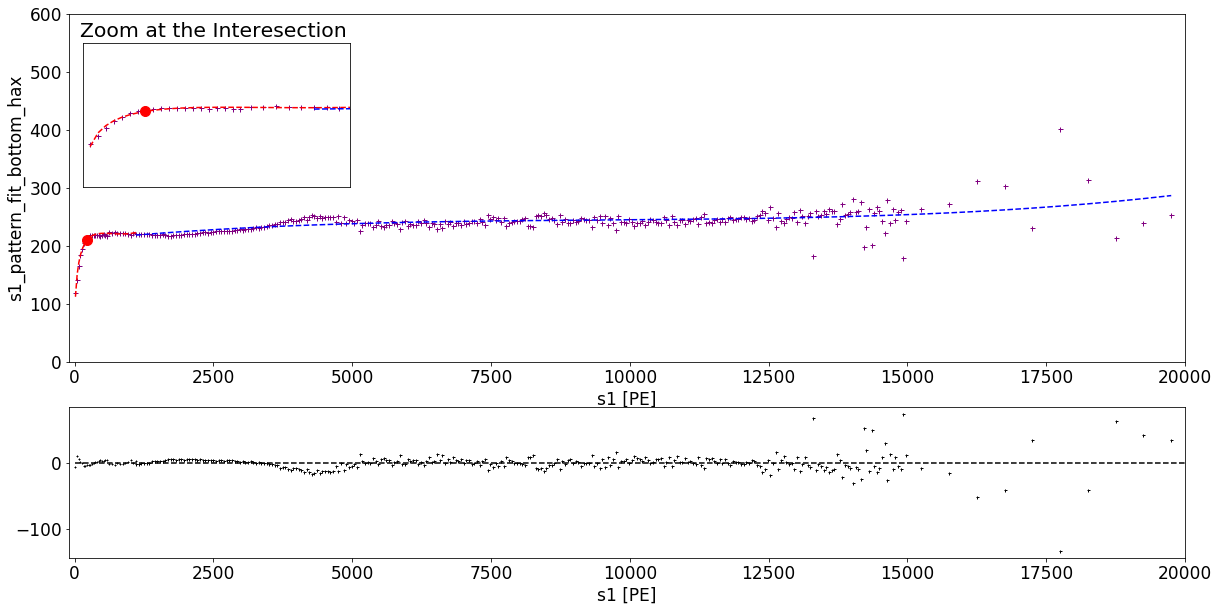

In [21]:
init_1 = [-5.02982285e+00, 2.70617850e+01, -6.85164479e-01, -1.63572624e-02]#, 6.10027892e-04]

popt_1, pcov_1 = curve_fit(S1PatternLikelihoodProfile_old_2, xbins_center_valid[:30], perc_valid[:30], p0=init_1)
print('popt_1: ', popt_1 ,'\n\npcov_1: ', pcov_1)

init_2 = [1.94732562e+02, 2.06418467e-02, -2.51207789e-06, 9.83912470e-11]

popt_2, pcov_2 = curve_fit(poly3, xbins_center_valid[30:], perc_valid[30:], p0=init_2)
print('\npopt_2: ',popt_2, '\n\npcov_2: ', pcov_2)

idx = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile_old_2(xbins_center_valid, *popt_1) - \
                                  poly3(xbins_center_valid, *popt_2)))).flatten()

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])

plt.plot(xbins_center_valid[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:31], *popt_1), 'r--')
plt.plot(xbins_center_valid[30:], poly3(xbins_center_valid[30:], *popt_2), 'b--')
plt.plot(xbins_center_valid[idx], S1PatternLikelihoodProfile_old_2(xbins_center_valid[idx], *popt_1), 'ro' , ms=10)
plt.xlim(-100, 2e4)
plt.ylim(0,600)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.axes([0.135, 0.64, .185, .2], facecolor='w')
plt.plot(xbins_center_valid[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid[:35], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:35], *popt_1), 'r--')
plt.plot(xbins_center_valid[25:], poly3(xbins_center_valid[25:], *popt_2), 'b--')
plt.plot(xbins_center_valid[idx], S1PatternLikelihoodProfile_old_2(xbins_center_valid[idx], *popt_1), 'ro' , ms=10)
plt.xlim(-10, 10e2)
plt.ylim(0,400)
plt.xticks([])
plt.yticks([])
plt.title('Zoom at the Interesection ')
#plt.xlabel('s1 [PE]')
#plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:31], *popt_1)-perc_valid[:31], 
         'k+', ms=2)
plt.plot(xbins_center_valid[30:], poly3(xbins_center_valid[30:], *popt_2)-perc_valid[30:], 
         'k+', ms=3)
plt.hlines(y=0, xmin=0, xmax=2e4, linestyles='dashed')
plt.xlim(-100, 2e4)
plt.xlabel('s1 [PE]')

plt.show()

In [22]:
xbins_center_valid[idx]

array([ 225.])

In [23]:
data_cut = data.copy()
data_cut['CutS1PF'] = (((data_cut['s1_pattern_fit_bottom_hax'] < S1PatternLikelihoodProfile_old_2(data_cut['s1'], *popt_1))*(data_cut['s1']<xbins_center_valid[idx][0]))
                      +((data_cut['s1_pattern_fit_bottom_hax'] < poly3(data_cut['s1'], *popt_2))*(data_cut['s1']>=xbins_center_valid[idx][0])))
data_cut = hax.cuts.selection(data_cut, data_cut['CutS1PF'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Unnamed selection: 15264 rows removed (98.19% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


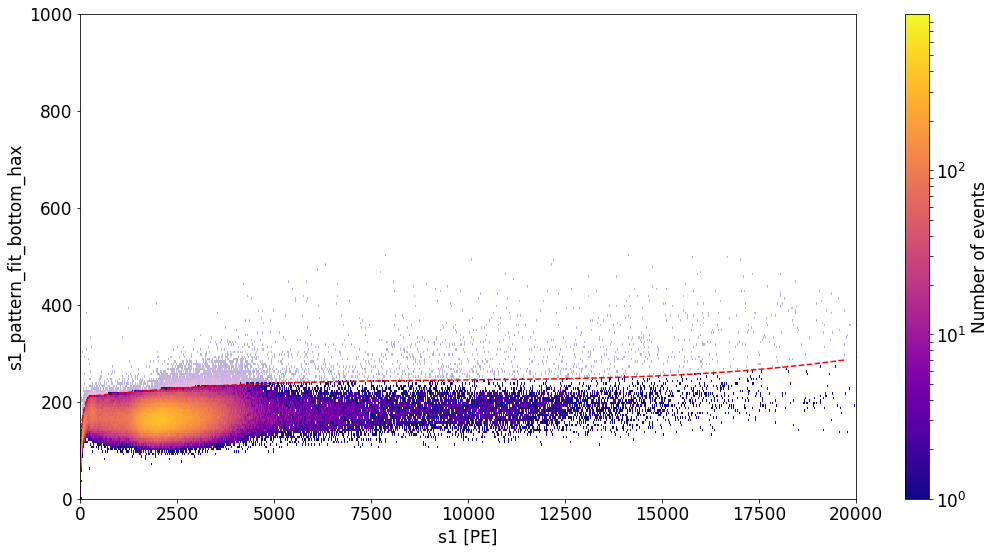

In [24]:
y_valid = []
for i in range(len(xbins_center_valid)):
    y_valid.append((S1PatternLikelihoodProfile_old_2(xbins_center_valid[i], *popt_1))*(xbins_center_valid[i]<xbins_center_valid[idx][0]) + \
                 (poly3(xbins_center_valid[i], *popt_2))*(xbins_center_valid[i]>=xbins_center_valid[idx][0]))

plt.figure(figsize=(15,8))
hist, xbins, ybins, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (2000, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.3)
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data_cut['s1'], data_cut['s1_pattern_fit_bottom_hax'], bins = (2000, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')
#plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()
hist[np.isnan(hist)] = 0
hist_cut[np.isnan(hist_cut)] = 0

In [25]:
len(data_cut)/len(data), hist_cut.sum()/hist.sum()

(0.9819170701483573, 0.98191707014835727)

In [26]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut)-1):
    bin_ = (xbins_cut[i+1] + xbins_cut[i])/2.
    acc = hist_cut[i].sum()/hist[i].sum()
    sig = np.sqrt(acc*(1-acc)/hist[i].sum())
    if np.isnan(acc)==False and acc!=0:
        bin_centers_acceptance.append(bin_)
        acceptance.append(acc)
        sigma.append(sig)
        print(bin_, acc, sig)
            
bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
#acceptance_nan = acceptance[np.logical_not(np.isnan(acceptance))]
#sigma_nan = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance)
acceptance_median = np.median(sigma)

print(acceptance_mean)

5.0 1.0 0.0
15.0 0.996230859835 0.000940507562554
25.0 0.996878901373 0.000985436614653
35.0 0.997293116783 0.00102172003659
45.0 0.995294117647 0.00148462505058
55.0 0.990909090909 0.00219482430354
65.0 0.986075949367 0.00294787752941
75.0 0.985724482512 0.00316923639165
85.0 0.984398216939 0.00337792495303
95.0 0.969943135662 0.00486649124089
105.0 0.970639032815 0.00496089202996
115.0 0.961759082218 0.00592968276192
125.0 0.969785575049 0.0053440602538
135.0 0.954098360656 0.00691831171561
145.0 0.957345971564 0.00695573873118
155.0 0.949677419355 0.00785269368391
165.0 0.961775585697 0.00673281787704
175.0 0.962516733601 0.00694964399992
185.0 0.954856361149 0.00767906981105
195.0 0.966325036603 0.00690247480784
205.0 0.964444444444 0.00712755300846
215.0 0.952180028129 0.00800256834308
225.0 0.974358974359 0.00580654889305
235.0 0.980169971671 0.00524698730571
245.0 0.966666666667 0.00655461386833
255.0 0.969855832241 0.00619003309444
265.0 0.973941368078 0.00524943300017
275.0 0.

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


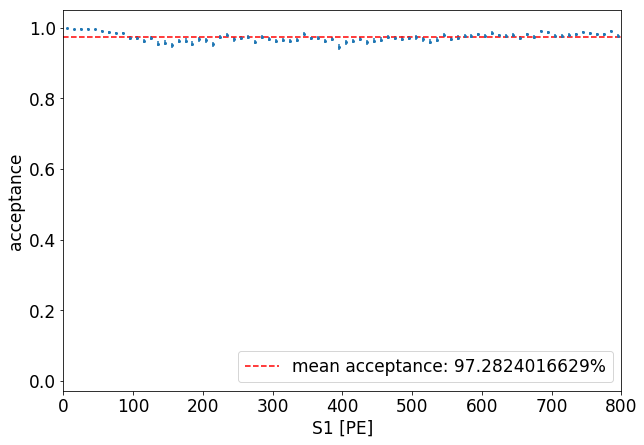

In [27]:
acceptance_mean = np.mean(acceptance[:80])
acceptance_median = np.median(acceptance[:80])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=8e2, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 800)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

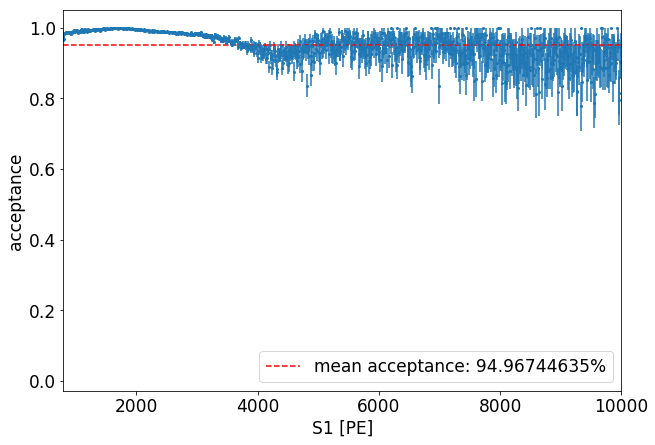

In [28]:
acceptance_mean = np.mean(acceptance[80:1000])
acceptance_median = np.median(acceptance[80:1000])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=8e2, xmax=1e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(8e2, 1e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

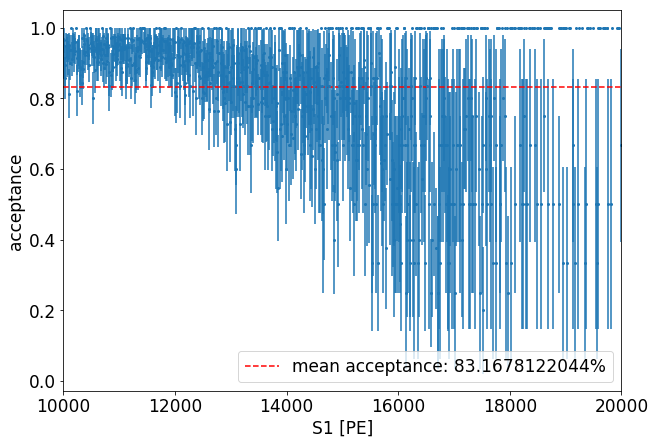

In [29]:
acceptance_mean = np.mean(acceptance[1000:])
acceptance_median = np.median(acceptance[1000:])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=1e4, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(1e4, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

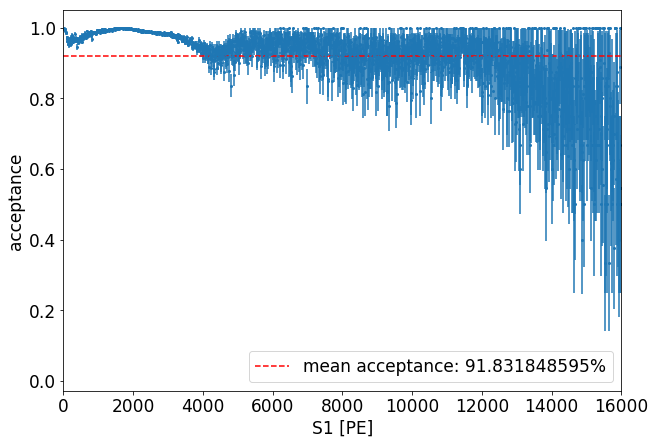

In [30]:
plt.figure(figsize=(10,7))

acceptance_mean = np.mean(acceptance[:1600])
acceptance_median = np.median(acceptance[:1600])

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 1.6e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

In [31]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


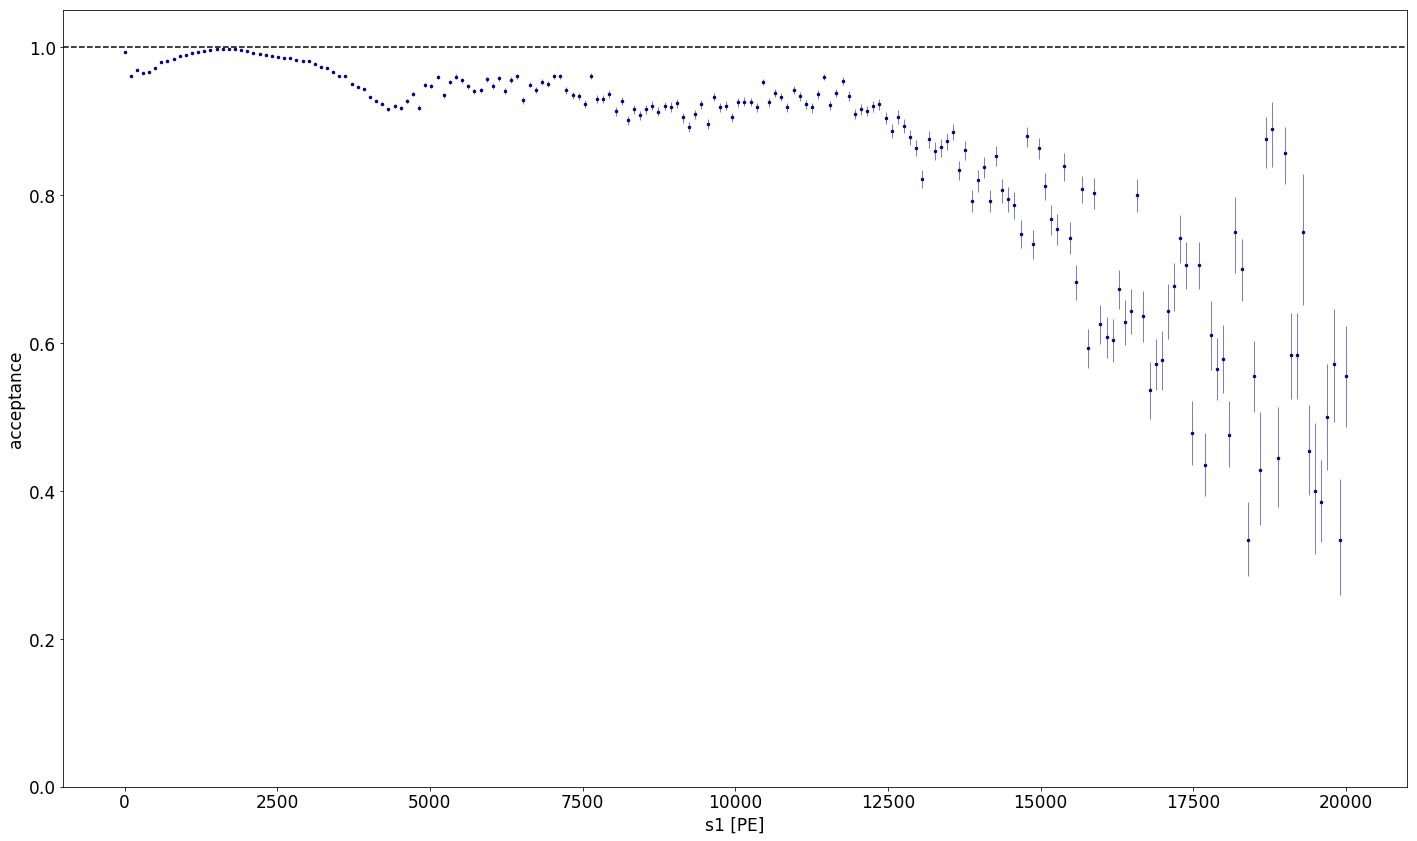

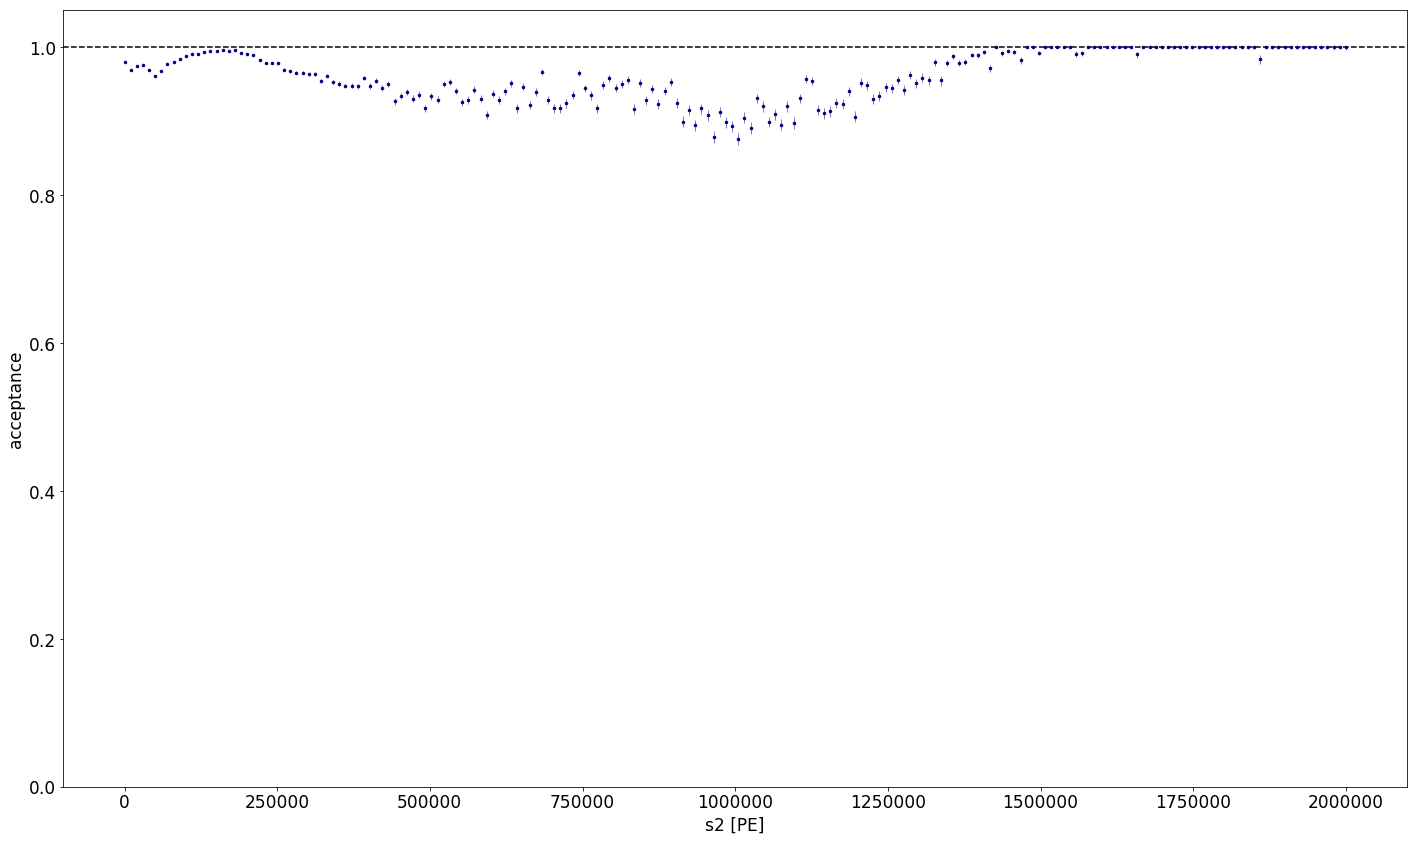

In [33]:
from statsmodels.stats.proportion import proportion_confint
binomial_error_method = 'wilson'
binomial_alpha = 0.68


def acceptance(data_before, data_after):
    after, bins=np.histogram(data_after ,bins=Bins, range=hist_range)
    before, bins=np.histogram(data_before ,bins=Bins, range=hist_range)

    acceptance = after/before
    error = proportion_confint(after, before, method=binomial_error_method, alpha=binomial_alpha)
    err_low = error[0]
    err_high = error[1]
    yerr_low, yerr_high = (acceptance - err_low, err_high - acceptance)
    err = (yerr_low, yerr_high)

    plt.errorbar(binn, acceptance, err,0, marker='.', markersize=5, linestyle="", linewidth=0.5, color='navy')
    plt.axhline(y=1, color='k',linestyle='--')
    plt.ylabel('acceptance')
    plt.ylim(0,1.05)
    
Bins=200
hist_range=([0,2e4])  
binn=np.linspace(0,2e4,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(data.s1, data_cut.s1)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('s1 [PE]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Bins=200
hist_range=([0,2e6])  
binn=np.linspace(0,2e6,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(data.s2, data_cut.s2)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('s2 [PE]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Acceptance study on xyz

In [34]:
data_cut_2 = data_cut.copy()
data_cut_2['theta_3d_nn_tf'] = 2 * np.pi * np.arctan(data_cut_2['y_3d_nn_tf']/data_cut_2['x_3d_nn_tf'])
tmp = data_cut_2.copy()
z1 = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
z2 = tmp[(tmp['z_3d_nn_tf']>-70) & (tmp['z_3d_nn_tf']<=-30)]
z3 = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-70)]
tmp = data.copy()
z1_white = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
z2_white = tmp[(tmp['z_3d_nn_tf']>-70) & (tmp['z_3d_nn_tf']<=-30)]
z3_white = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-70)]
del tmp

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


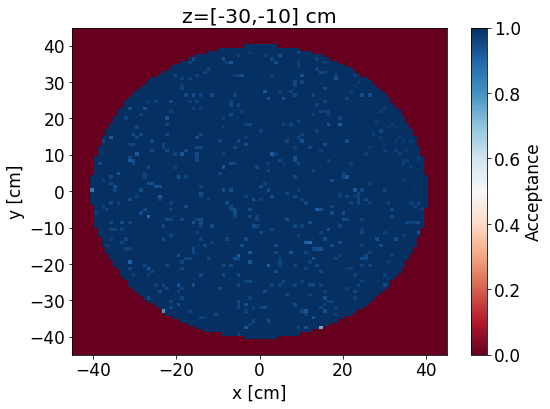

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


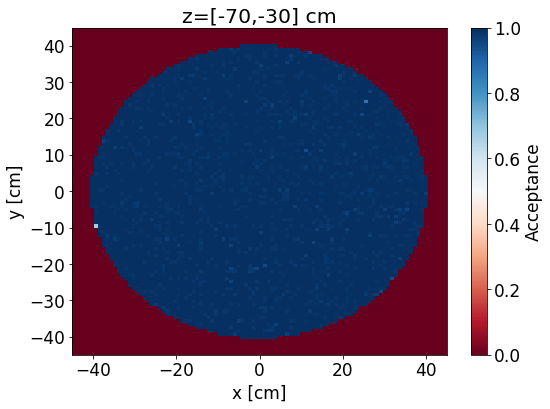

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in true_divide


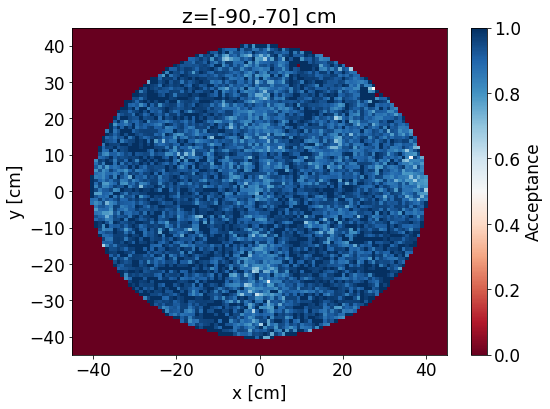

In [ ]:
plt.figure(figsize=(8,6))
hist_data_1, x_data_1, y_data_1 = np.histogram2d(z1_white['x_3d_nn_tf'], z1_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_1, x_cut_1, y_cut_1 = np.histogram2d(z1['x_3d_nn_tf'], z1['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_1 = hist_cut_1/hist_data_1
c_1 = plt.pcolor(x_data_1, y_data_1, Acceptance_xy_1, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_1, label='Acceptance')
plt.title('z=[-30,-10] cm')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
hist_data_2, x_data_2, y_data_2 = np.histogram2d(z2_white['x_3d_nn_tf'], z2_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_2, x_cut_2, y_cut_2 = np.histogram2d(z2['x_3d_nn_tf'], z2['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_2 = hist_cut_2/hist_data_2
c_2 = plt.pcolor(x_data_2, y_data_2, Acceptance_xy_2, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_2, label='Acceptance')
plt.title('z=[-70,-30] cm')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
hist_data_3, x_data_3, y_data_3 = np.histogram2d(z3_white['x_3d_nn_tf'], z3_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_3, x_cut_3, y_cut_3 = np.histogram2d(z3['x_3d_nn_tf'], z3['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_3 = hist_cut_3/hist_data_3
c_3 = plt.pcolor(x_data_3, y_data_3, Acceptance_xy_3, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_3, label='Acceptance')
plt.title('z=[-90,-70] cm')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()
plt.show()


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/statsmodels/stats/proportion.py:68: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/statsmodels/stats/proportion.py:111: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1 + crit2 / nobs
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/statsmodels/stats/proportion.py:112: RuntimeWarning: divide by zero encountered in true_divide
  center = (q_ + crit2 / (2 * nobs)) / denom
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/statsmodels/stats/proportion.py:113: RuntimeWarning: divide by zero encountered in true_divide
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))
/project/lgrandi/anaconda

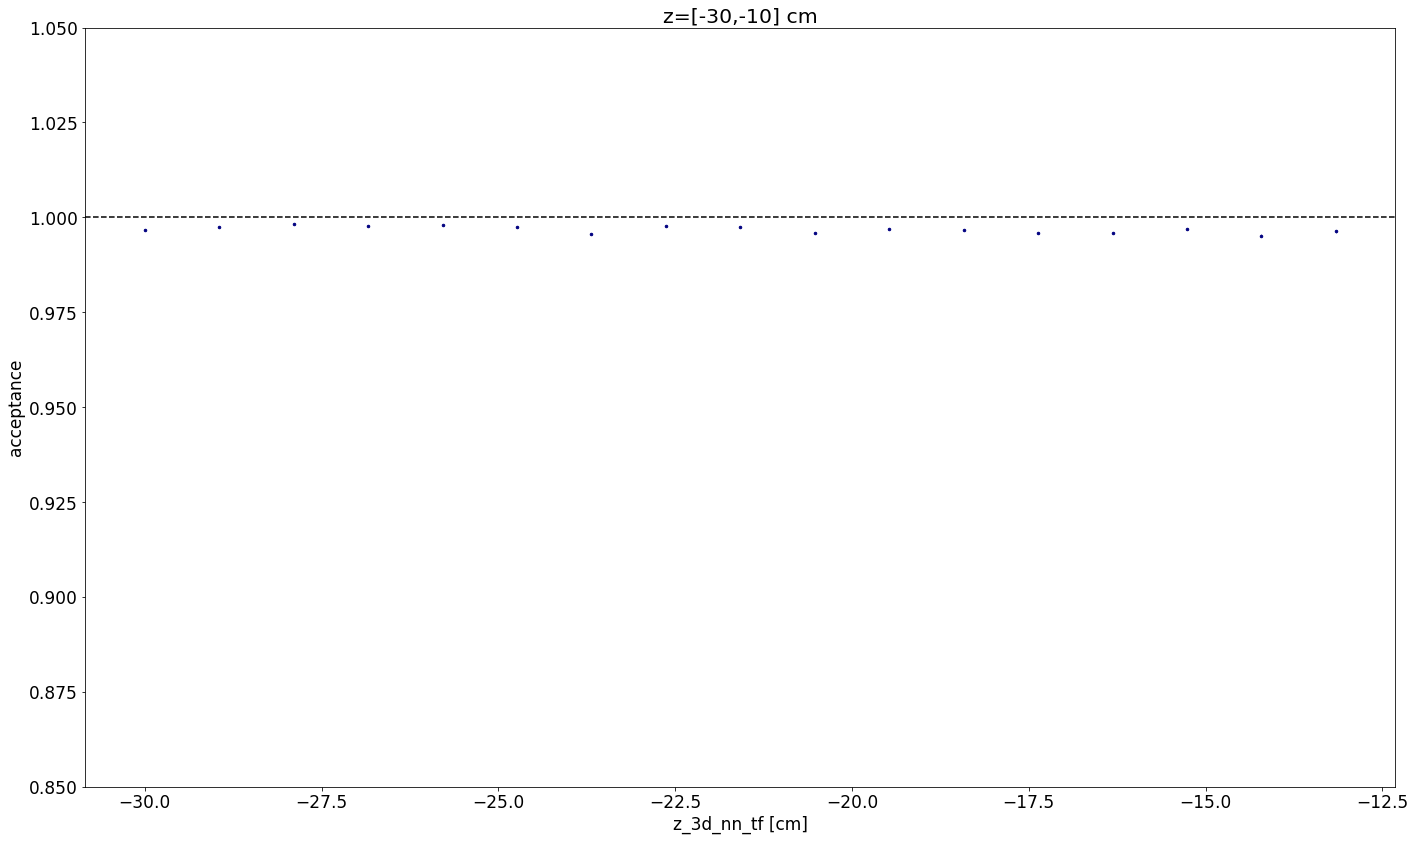

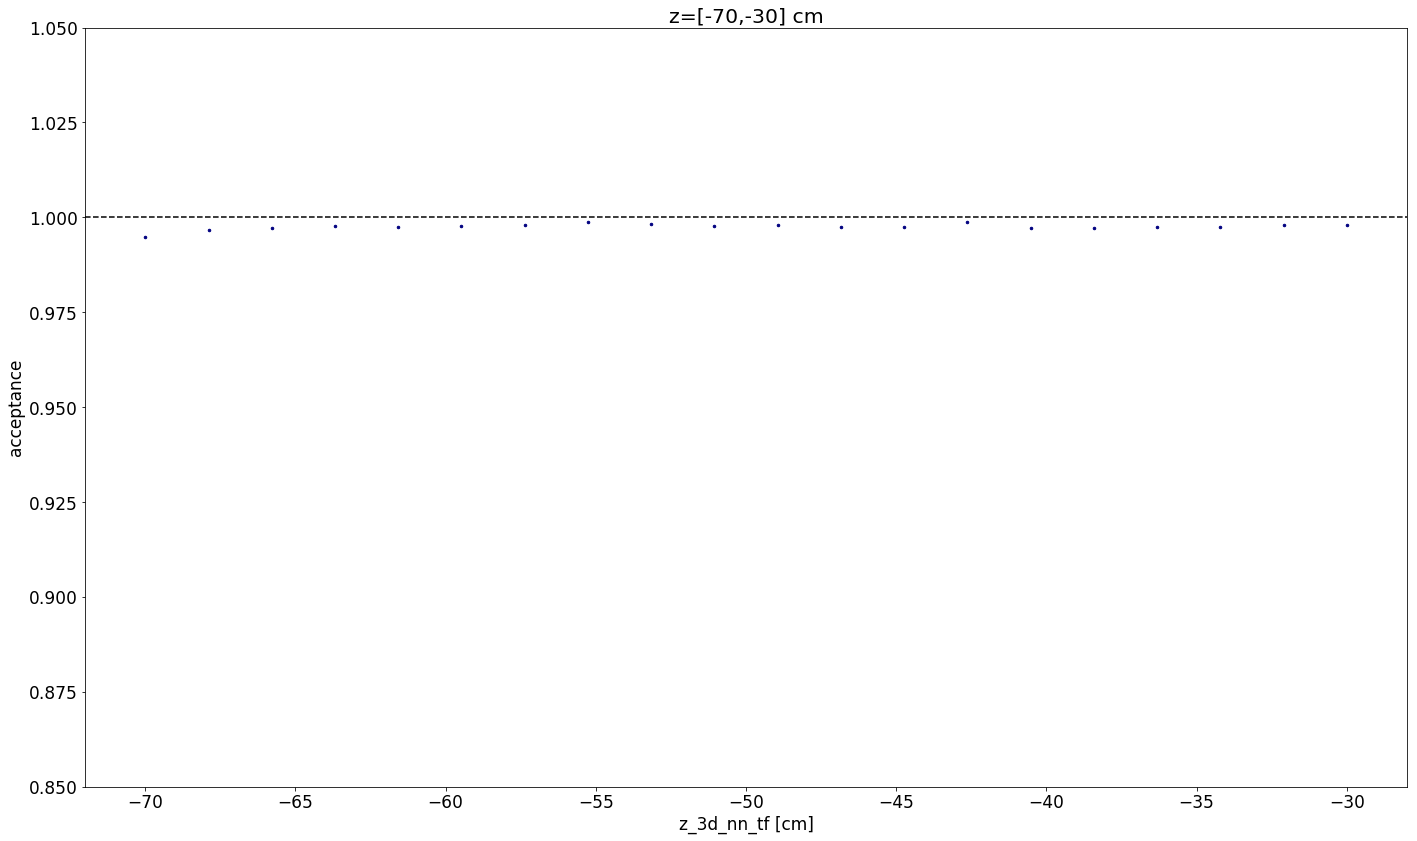

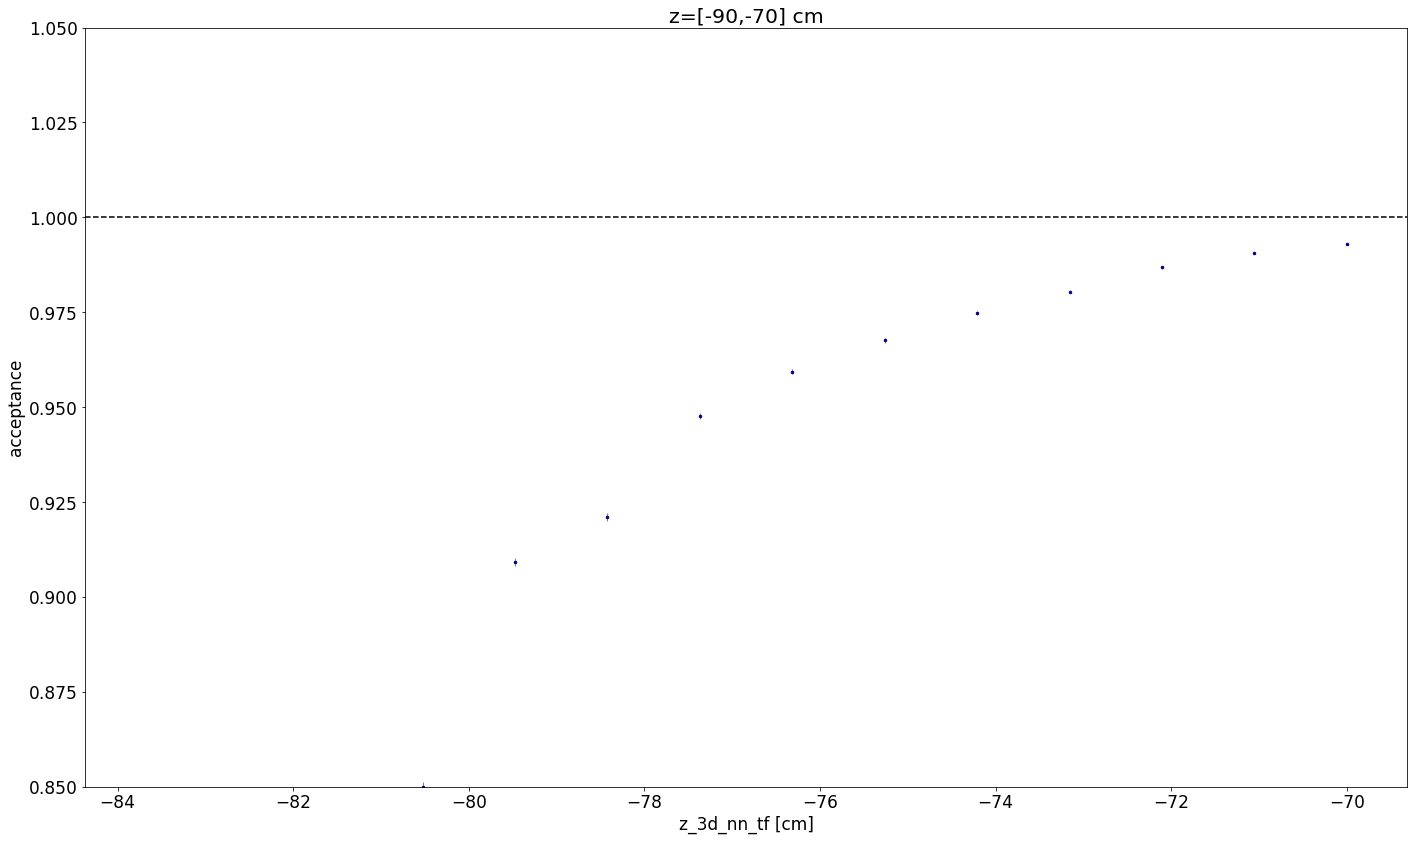

In [ ]:
plt.figure(figsize=(8,6))
Bins=20
hist_range=([-30, -10])  
binn=np.linspace(-30,-10,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(z1_white.z_3d_nn_tf, z1.z_3d_nn_tf)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.title('z=[-30,-10] cm')
plt.xlabel('z_3d_nn_tf [cm]')
plt.legend(loc='best')
plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
Bins=20
hist_range=([-70, -30])  
binn=np.linspace(-70,-30,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(z2_white.z_3d_nn_tf, z2.z_3d_nn_tf)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.title('z=[-70,-30] cm')
plt.xlabel('z_3d_nn_tf [cm]')
plt.legend(loc='best')
plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
Bins=20
hist_range=([-90, -70])  
binn=np.linspace(-90,-70,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(z3_white.z_3d_nn_tf, z3.z_3d_nn_tf)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.title('z=[-90,-70] cm')
plt.xlabel('z_3d_nn_tf [cm]')
plt.legend(loc='best')
plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()